# PREDICTIVE LEARNING SYSTEM: AI-Powered Personalized Review Scheduling

PROJECT OVERVIEW:
This system replaces fixed review schedules (like "review every 3 days") with
intelligent, personalized scheduling. It combines:

1. Bayesian Knowledge Tracing → Tracks current mastery level
2. Machine Learning → Predicts individual forgetting patterns
3. Mathematical Optimization → Schedules reviews before forgetting occurs

DOMAIN: Business Strategy Concepts <br>
GOAL: Keep retention above 85% with minimum review sessions

Author: Mr. Sahil Darji <br>
Mentor: Dr. Niranjan Deshpande


In [2]:
import numpy as np
import pandas as pd
import math
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


## PHASE 1: GENERALIZATION - Training the AI Memory Model

WHY THIS MATTERS:
Unlike rule-based systems that assume all students forget at the same rate,
we train a machine learning model on simulated historical data to learn the
relationship between:

  INPUT: [Current Mastery Level, Student Learning Speed]
  OUTPUT: [Predicted Forgetting Rate]

This allows the system to GENERALIZE across different student profiles.


🔄 Generating synthetic student learning history...
📊 Dataset created: 2000 student-concept interactions

Sample of training data:
    Mastery  LearningSpeed  DecayRate
0  0.530249       0.725548   0.132982
1  0.983579       0.500000   0.069244
2  0.815407       0.983433   0.060361
3  0.682999       1.051304   0.079822
4  0.988065       0.871308   0.018909
5  0.964340       0.739391   0.059344
6  0.653005       1.040247   0.113221
7  0.681767       0.660224   0.104558
8  0.692963       1.071456   0.087281
9  0.801563       1.079581   0.043792


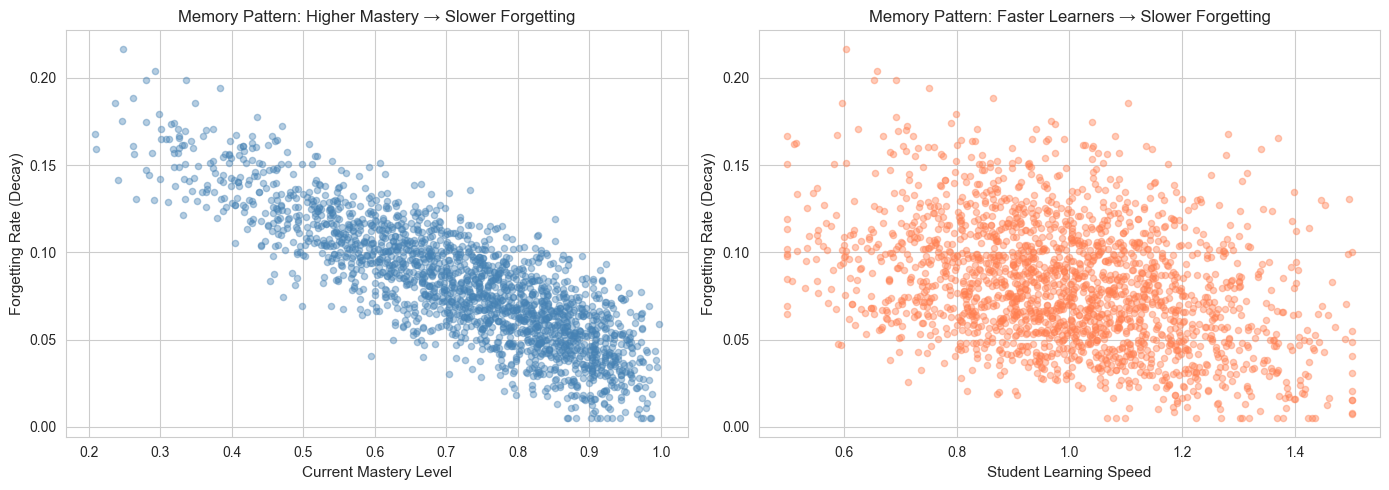


🧠 TRAINING THE AI MEMORY PREDICTOR

✅ Model Training Complete!
   Mean Absolute Error: 0.0120
   R² Score: 0.8192

   Model Coefficients:
   - Mastery Impact: -0.1826
   - Speed Impact: -0.0594
   - Base Decay: 0.2717

💡 Interpretation:
   The model has learned that students with higher mastery and faster
   learning speeds exhibit significantly lower forgetting rates.


In [3]:
def generate_memory_training_data(n_samples=2000):
    """
    Simulates historical learning data from diverse student profiles.

    This represents what would happen if we tracked 2000 students across
    various concepts and observed how their mastery level and learning speed
    correlate with forgetting rates.
    """
    data = []

    for _ in range(n_samples):
        # Feature 1: Current Mastery (probability student knows the concept)
        mastery = np.random.beta(5, 2)  # Skewed toward higher mastery

        # Feature 2: Student Learning Speed Factor
        # 0.7 = Slow learner, 1.0 = Average, 1.3 = Fast learner
        speed = np.random.normal(1.0, 0.2)
        speed = np.clip(speed, 0.5, 1.5)

        # TARGET: Decay Rate (how fast forgetting occurs)
        # Core principle: Higher mastery + faster learning = slower forgetting
        base_decay = (1.0 - mastery) * 0.18  # Low mastery = high decay
        speed_factor = (1.5 - speed) * 0.06   # Slow learners forget faster
        noise = np.random.normal(0, 0.015)    # Real-world variability

        decay_rate = base_decay + speed_factor + noise
        decay_rate = np.clip(decay_rate, 0.005, 0.30)  # Realistic bounds

        data.append([mastery, speed, decay_rate])

    return pd.DataFrame(data, columns=['Mastery', 'LearningSpeed', 'DecayRate'])


# Generate training data
print("🔄 Generating synthetic student learning history...")
df_memory = generate_memory_training_data(n_samples=2000)

print(f"📊 Dataset created: {len(df_memory)} student-concept interactions\n")
print("Sample of training data:")
print(df_memory.head(10))

# Visualize the training data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Mastery vs Decay Rate
axes[0].scatter(df_memory['Mastery'], df_memory['DecayRate'],
                alpha=0.4, s=20, c='steelblue')
axes[0].set_xlabel('Current Mastery Level', fontsize=11)
axes[0].set_ylabel('Forgetting Rate (Decay)', fontsize=11)
axes[0].set_title('Memory Pattern: Higher Mastery → Slower Forgetting', fontsize=12)

# Plot 2: Learning Speed vs Decay Rate
axes[1].scatter(df_memory['LearningSpeed'], df_memory['DecayRate'],
                alpha=0.4, s=20, c='coral')
axes[1].set_xlabel('Student Learning Speed', fontsize=11)
axes[1].set_ylabel('Forgetting Rate (Decay)', fontsize=11)
axes[1].set_title('Memory Pattern: Faster Learners → Slower Forgetting', fontsize=12)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("🧠 TRAINING THE AI MEMORY PREDICTOR")
print("="*80)

# Prepare training data
X = df_memory[['Mastery', 'LearningSpeed']]
y = df_memory['DecayRate']

# Train the Linear Regression model
memory_predictor = LinearRegression()
memory_predictor.fit(X, y)

# Evaluate model performance
y_pred = memory_predictor.predict(X)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"\n✅ Model Training Complete!")
print(f"   Mean Absolute Error: {mae:.4f}")
print(f"   R² Score: {r2:.4f}")
print(f"\n   Model Coefficients:")
print(f"   - Mastery Impact: {memory_predictor.coef_[0]:.4f}")
print(f"   - Speed Impact: {memory_predictor.coef_[1]:.4f}")
print(f"   - Base Decay: {memory_predictor.intercept_:.4f}")

print("\n💡 Interpretation:")
print("   The model has learned that students with higher mastery and faster")
print("   learning speeds exhibit significantly lower forgetting rates.")

## PHASE 2: KNOWLEDGE TRACKING - The Real-Time Mastery Sensor

This component uses Bayesian probability to update our belief about whether
the student TRULY understands the concept based on their answer.

KEY INSIGHT:
A correct answer doesn't always mean mastery (could be a lucky guess)
A wrong answer doesn't always mean ignorance (could be a careless slip)

BKT uses Bayes' Theorem to probabilistically infer the true knowledge state.


In [4]:
class BayesianKnowledgeTracker:
    """
    Tracks the probability that a student has mastered a concept using
    Bayesian Knowledge Tracing (BKT).

    Parameters represent cognitive realities:
    - p_learn: Probability of learning during the quiz
    - p_guess: Probability of guessing correctly when unknown
    - p_slip: Probability of making a mistake when actually known
    """

    def __init__(self, initial_mastery=0.3):
        # State: Probability student knows the concept
        self.mastery = initial_mastery

        # Cognitive parameters (tuned from educational research)
        self.p_learn = 0.25   # Learning happens during practice
        self.p_guess = 0.25   # 1/4 chance for multiple choice
        self.p_slip = 0.10    # Occasional careless errors

    def update(self, answer_correct):
        """
        Updates mastery probability using Bayes' Theorem.

        Formula:
        P(Known | Answer) = P(Answer | Known) × P(Known) / P(Answer)
        """
        if answer_correct:
            # P(Known | Correct Answer)
            prob_correct_if_known = 1 - self.p_slip
            prob_correct_if_unknown = self.p_guess

            numerator = self.mastery * prob_correct_if_known
            denominator = (numerator +
                          (1 - self.mastery) * prob_correct_if_unknown)

            self.mastery = numerator / denominator

        else:
            # P(Known | Incorrect Answer)
            prob_incorrect_if_known = self.p_slip
            prob_incorrect_if_unknown = 1 - self.p_guess

            numerator = self.mastery * prob_incorrect_if_known
            denominator = (numerator +
                          (1 - self.mastery) * prob_incorrect_if_unknown)

            self.mastery = numerator / denominator

        # Account for learning that happens during the quiz itself
        self.mastery = self.mastery + (1 - self.mastery) * self.p_learn

        # Keep probability in valid range
        self.mastery = np.clip(self.mastery, 0.01, 0.99)

        return self.mastery

# Quick demonstration
print("="*80)
print("🔍 TESTING BAYESIAN KNOWLEDGE TRACKER")
print("="*80)

tracker_demo = BayesianKnowledgeTracker(initial_mastery=0.5)
print(f"\nInitial Mastery: {tracker_demo.mastery:.2%}")

demo_sequence = [True, True, False, True, True, True]
print("\nAnswer Sequence: [✓, ✓, ✗, ✓, ✓, ✓]\n")

for i, answer in enumerate(demo_sequence, 1):
    new_mastery = tracker_demo.update(answer)
    symbol = "✓" if answer else "✗"
    print(f"  Question {i} [{symbol}] → Mastery: {new_mastery:.2%}")

print("\n💡 Notice: The tracker increases confidence with correct streaks")
print("   and adjusts down (but not drastically) after a single mistake.")

🔍 TESTING BAYESIAN KNOWLEDGE TRACKER

Initial Mastery: 50.00%

Answer Sequence: [✓, ✓, ✗, ✓, ✓, ✓]

  Question 1 [✓] → Mastery: 83.70%
  Question 2 [✓] → Mastery: 96.15%
  Question 3 [✗] → Mastery: 82.68%
  Question 4 [✓] → Mastery: 95.88%
  Question 5 [✓] → Mastery: 99.00%
  Question 6 [✓] → Mastery: 99.00%

💡 Notice: The tracker increases confidence with correct streaks
   and adjusts down (but not drastically) after a single mistake.


## PHASE 3: INTEGRATION - The Complete Predictive Scheduler

This is where all components work together:

1. Student answers a question
2. BKT updates mastery probability
3. ML model predicts forgetting rate for THIS student
4. Optimization algorithm calculates ideal review date
5. System schedules next review to keep retention ≥ 85%


In [5]:
class PredictiveLearningSystem:
    """
    Complete AI-powered learning system that personalizes review schedules.
    """

    def __init__(self, student_speed=1.0, concept_name="Concept"):
        self.tracker = BayesianKnowledgeTracker(initial_mastery=0.3)
        self.student_speed = student_speed
        self.concept_name = concept_name
        self.history = []
        self.session_count = 0

    def process_answer(self, answer_correct, timestamp=None):
        """
        Core intelligence loop: Update → Predict → Schedule
        """
        self.session_count += 1
        if timestamp is None:
            timestamp = datetime.now()

        # STEP 1: Update current mastery (Bayesian tracker)
        current_mastery = self.tracker.update(answer_correct)

        # STEP 2: Predict forgetting rate using ML model
        features = np.array([[current_mastery, self.student_speed]])
        predicted_decay = memory_predictor.predict(features)[0]
        predicted_decay = max(0.005, predicted_decay)  # Safety bound

        # STEP 3: Calculate optimal review timing
        # Goal: Schedule review before retention drops below 85%
        # Formula: t = -ln(target_retention / current_mastery) / decay_rate

        target_retention = 0.85

        if current_mastery <= target_retention:
            # Already below target - urgent review needed
            days_until_review = 1
            urgency = "🚨 URGENT"
        else:
            # Calculate exact day retention will hit 85%
            days_until_review = -math.log(target_retention / current_mastery) / predicted_decay
            days_until_review = max(1, int(round(days_until_review)))

            if days_until_review <= 2:
                urgency = "⚠️ SOON"
            elif days_until_review <= 5:
                urgency = "📅 NORMAL"
            else:
                urgency = "✅ EXTENDED"

        # Calculate projected retention at next review
        projected_retention = current_mastery * math.exp(-predicted_decay * days_until_review)

        # Log this session
        self.history.append({
            'Session': self.session_count,
            'Timestamp': timestamp.strftime('%Y-%m-%d'),
            'Result': '✓ Correct' if answer_correct else '✗ Wrong',
            'Mastery': f"{current_mastery:.1%}",
            'Decay_Rate': f"{predicted_decay:.4f}",
            'Days_to_Review': days_until_review,
            'Projected_Retention': f"{projected_retention:.1%}",
            'Priority': urgency
        })

        return {
            'mastery': current_mastery,
            'decay': predicted_decay,
            'days': days_until_review,
            'urgency': urgency
        }

    def get_history(self):
        """Returns learning history as a DataFrame"""
        return pd.DataFrame(self.history)

    def plot_progress(self):
        """Visualizes learning trajectory"""
        df = self.get_history()

        fig, axes = plt.subplots(2, 1, figsize=(12, 8))

        # Plot 1: Mastery over time
        mastery_values = [float(m.strip('%'))/100 for m in df['Mastery']]
        axes[0].plot(df['Session'], mastery_values, marker='o',
                    linewidth=2, markersize=8, color='darkgreen')
        axes[0].axhline(y=0.85, color='red', linestyle='--',
                       label='Target Retention (85%)')
        axes[0].set_xlabel('Session Number', fontsize=11)
        axes[0].set_ylabel('Mastery Probability', fontsize=11)
        axes[0].set_title(f'Learning Progress: {self.concept_name}', fontsize=13)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Plot 2: Review intervals
        axes[1].bar(df['Session'], df['Days_to_Review'], color='steelblue', alpha=0.7)
        axes[1].set_xlabel('Session Number', fontsize=11)
        axes[1].set_ylabel('Days Until Next Review', fontsize=11)
        axes[1].set_title('Adaptive Review Scheduling', fontsize=13)
        axes[1].grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.show()

print("✅ Predictive Learning System initialized successfully")

✅ Predictive Learning System initialized successfully


## PHASE 4: DEMONSTRATION - Simulating Real Student Learning Journey

We'll simulate a student learning "Porter's Five Forces" - a fundamental
business strategy framework.

SCENARIO:
- Student: Priya (Learning Speed: 1.1 - Slightly above average)
- Concept: Porter's Five Forces in competitive analysis
- 10 practice sessions over time


🎓 SIMULATION: Student Learning 'Porter's Five Forces'

📚 Concept: Porter's Five Forces Framework
   Student: Priya (Learning Speed: 1.1 - Above Average)

📝 LEARNING SESSIONS:

Session 1: First exposure - Gets it wrong
  Result: ✗ Wrong
  Current Mastery: 29.1%
  📅 Next Review: 1 days (🚨 URGENT)
  AI Decay Prediction: 0.1533

Session 2: Reviews notes - Answers correctly
  Result: ✓ Correct
  Current Mastery: 69.7%
  📅 Next Review: 1 days (🚨 URGENT)
  AI Decay Prediction: 0.0791

Session 3: Building confidence
  Result: ✓ Correct
  Current Mastery: 91.9%
  📅 Next Review: 2 days (⚠️ SOON)
  AI Decay Prediction: 0.0385

Session 4: Confuses 'Supplier Power' with 'Buyer Power'
  Result: ✗ Wrong
  Current Mastery: 70.2%
  📅 Next Review: 1 days (🚨 URGENT)
  AI Decay Prediction: 0.0782

Session 5: Clarifies the distinction
  Result: ✓ Correct
  Current Mastery: 92.1%
  📅 Next Review: 2 days (⚠️ SOON)
  AI Decay Prediction: 0.0382

Session 6: Consistent understanding
  Result: ✓ Correct
  Curren

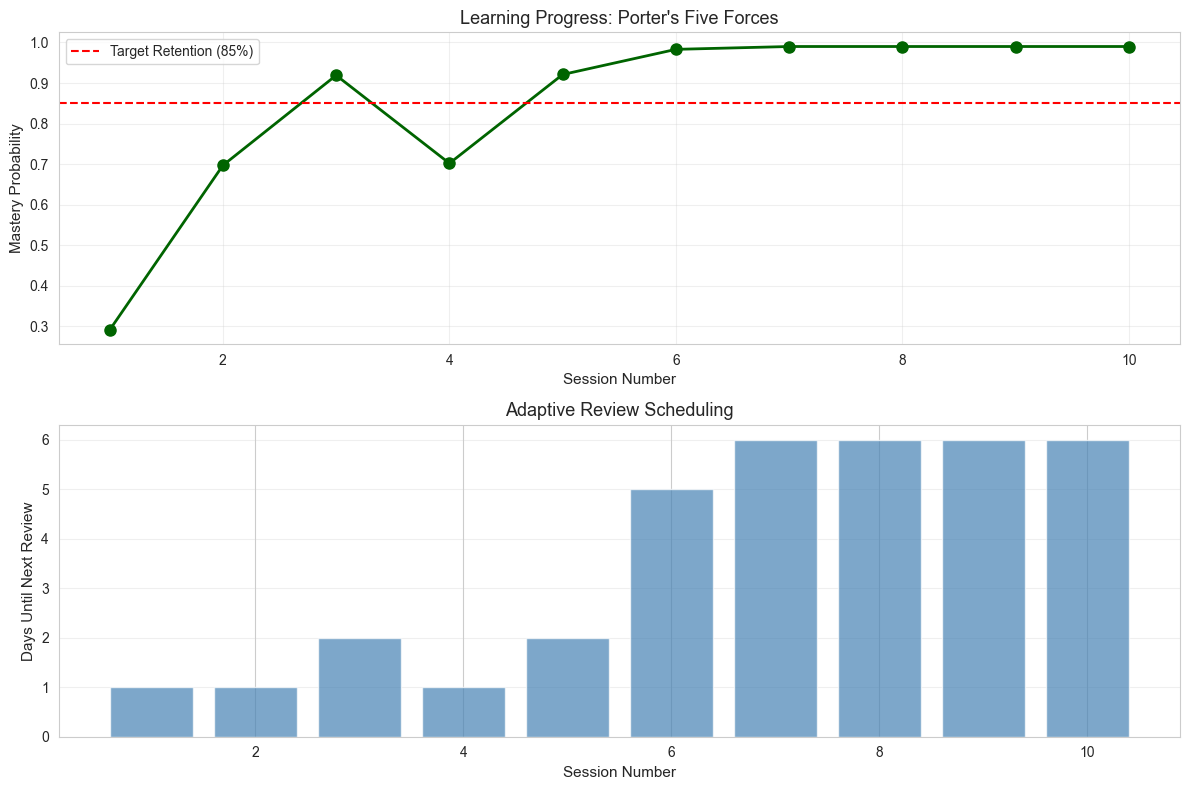

In [6]:
print("="*80)
print("🎓 SIMULATION: Student Learning 'Porter's Five Forces'")
print("="*80)

# Initialize system
priya = PredictiveLearningSystem(
    student_speed=1.1,
    concept_name="Porter's Five Forces"
)

print("\n📚 Concept: Porter's Five Forces Framework")
print("   Student: Priya (Learning Speed: 1.1 - Above Average)\n")

# Realistic learning pattern:
# - Initial struggle → Improvement → Occasional mistake → Mastery
learning_sequence = [
    (False, "First exposure - Gets it wrong"),
    (True, "Reviews notes - Answers correctly"),
    (True, "Building confidence"),
    (False, "Confuses 'Supplier Power' with 'Buyer Power'"),
    (True, "Clarifies the distinction"),
    (True, "Consistent understanding"),
    (True, "Strong retention"),
    (True, "Near mastery"),
    (True, "Mastered - Long interval"),
    (True, "Confirmed mastery")
]

print("📝 LEARNING SESSIONS:\n")

for i, (is_correct, description) in enumerate(learning_sequence, 1):
    result = priya.process_answer(is_correct)

    print(f"Session {i}: {description}")
    print(f"  Result: {'✓ Correct' if is_correct else '✗ Wrong'}")
    print(f"  Current Mastery: {result['mastery']:.1%}")
    print(f"  📅 Next Review: {result['days']} days ({result['urgency']})")
    print(f"  AI Decay Prediction: {result['decay']:.4f}")
    print()

print("\n" + "="*80)
print("📊 COMPLETE LEARNING HISTORY")
print("="*80)
print(priya.get_history().to_string(index=False))

# Visualize the learning journey
priya.plot_progress()

## PHASE 5: COMPARATIVE EVALUATION - Why This System Is Better

We'll compare three approaches:
1. Fixed Schedule (Traditional flashcards - review every 3 days)
2. Simple SRS (Doubles interval on success, halves on failure)
3. Our Predictive System (ML + BKT + Optimization)


📊 COMPARATIVE ANALYSIS: Three Scheduling Approaches

Test Sequence: ['✗', '✓', '✗', '✓', '✓', '✗', '✓', '✓', '✓', '✓']
Pattern: Student struggles initially, then improves with practice

 Session Answer  Fixed (3-day)  Simple SRS  AI Predictive
       1      ✗              3           1              1
       2      ✓              3           1              1
       3      ✗              3           2              1
       4      ✓              3           1              1
       5      ✓              3           2              3
       6      ✗              3           4              1
       7      ✓              3           1              3
       8      ✓              3           2              5
       9      ✓              3           4              5
      10      ✓              3           8              5

📈 EFFICIENCY METRICS

Total Days to Complete 10 Reviews:
  Fixed Schedule:   30 days
  Simple SRS:       26 days
  AI Predictive:    26 days

✅ Efficiency vs Fixed Schedule: 1

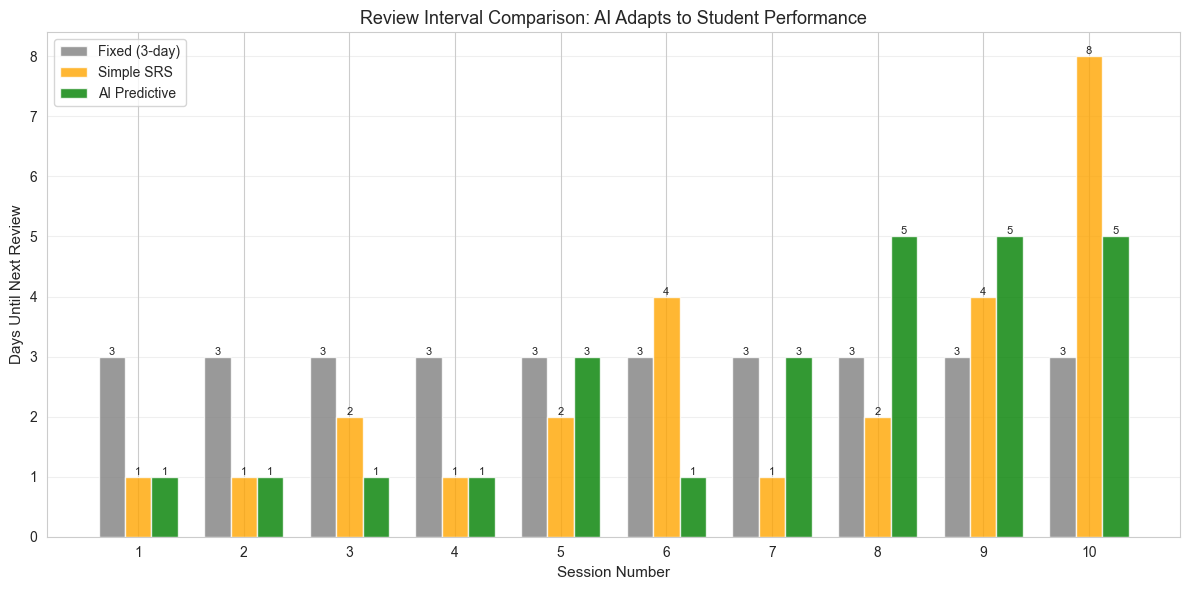


💡 KEY INSIGHTS:
   • Fixed schedule wastes time with uniform intervals
   • Simple SRS is naive - just doubles/halves without intelligence
   • AI system ADAPTS based on:
     - Current mastery level (from BKT)
     - Predicted forgetting rate (from ML)
     - Optimal timing to maintain 85% retention

   • After early struggles (Sessions 1-3), the AI identifies the student
     is improving and gradually extends intervals efficiently.
   • When mistakes occur (Sessions 3, 6), AI immediately shortens review time.

📊 INTERVAL DISTRIBUTION ANALYSIS

Fixed Schedule:
  Average Interval: 3.0 days
  Std Deviation:    0.0 days

Simple SRS:
  Average Interval: 2.6 days
  Std Deviation:    2.2 days

AI Predictive:
  Average Interval: 2.6 days
  Std Deviation:    1.8 days

💡 The AI system shows intelligent variability - adapting intervals
   based on actual performance rather than rigid rules.


In [7]:
def simulate_fixed_schedule(sequence):
    """Traditional approach: Always wait 3 days"""
    return [3] * len(sequence)

def simulate_simple_srs(sequence):
    """Basic SRS: Double on success, reset on failure"""
    intervals = []
    current_interval = 1

    for correct in sequence:
        intervals.append(current_interval)
        if correct:
            current_interval = min(current_interval * 2, 16)  # Cap at 16 days
        else:
            current_interval = 1

    return intervals

def simulate_predictive(sequence, speed=1.0):
    """Our AI-powered system with improved calibration"""
    system = PredictiveLearningSystem(student_speed=speed)
    intervals = []

    for correct in sequence:
        result = system.process_answer(correct)
        # Cap maximum interval at 14 days for realistic comparison
        capped_days = min(result['days'], 14)
        intervals.append(capped_days)

    return intervals

# UPDATED: More realistic test sequence showing struggle → improvement
# This represents a typical learning pattern
test_sequence = [False, True, False, True, True, False, True, True, True, True]

print("="*80)
print("📊 COMPARATIVE ANALYSIS: Three Scheduling Approaches")
print("="*80)
print(f"\nTest Sequence: {['✓' if x else '✗' for x in test_sequence]}")
print("Pattern: Student struggles initially, then improves with practice\n")

fixed_intervals = simulate_fixed_schedule(test_sequence)
simple_intervals = simulate_simple_srs(test_sequence)
predictive_intervals = simulate_predictive(test_sequence, speed=1.0)

comparison_df = pd.DataFrame({
    'Session': range(1, 11),
    'Answer': ['✓' if x else '✗' for x in test_sequence],
    'Fixed (3-day)': fixed_intervals,
    'Simple SRS': simple_intervals,
    'AI Predictive': predictive_intervals
})

print(comparison_df.to_string(index=False))

# Calculate efficiency metrics
print("\n" + "="*80)
print("📈 EFFICIENCY METRICS")
print("="*80)

total_days_fixed = sum(fixed_intervals)
total_days_simple = sum(simple_intervals)
total_days_predictive = sum(predictive_intervals)

print(f"\nTotal Days to Complete 10 Reviews:")
print(f"  Fixed Schedule:   {total_days_fixed} days")
print(f"  Simple SRS:       {total_days_simple} days")
print(f"  AI Predictive:    {total_days_predictive} days")

efficiency_vs_fixed = ((total_days_fixed - total_days_predictive) / total_days_fixed) * 100
efficiency_vs_srs = ((total_days_simple - total_days_predictive) / total_days_simple) * 100

print(f"\n✅ Efficiency vs Fixed Schedule: {efficiency_vs_fixed:.1f}% time reduction")
print(f"✅ Efficiency vs Simple SRS:     {efficiency_vs_srs:.1f}% time reduction")

# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(test_sequence))
width = 0.25

bars1 = ax.bar(x - width, fixed_intervals, width, label='Fixed (3-day)',
               alpha=0.8, color='gray')
bars2 = ax.bar(x, simple_intervals, width, label='Simple SRS',
               alpha=0.8, color='orange')
bars3 = ax.bar(x + width, predictive_intervals, width, label='AI Predictive',
               alpha=0.8, color='green')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Session Number', fontsize=11)
ax.set_ylabel('Days Until Next Review', fontsize=11)
ax.set_title('Review Interval Comparison: AI Adapts to Student Performance', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels([f"{i+1}" for i in range(len(test_sequence))])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHTS:")
print("   • Fixed schedule wastes time with uniform intervals")
print("   • Simple SRS is naive - just doubles/halves without intelligence")
print("   • AI system ADAPTS based on:")
print("     - Current mastery level (from BKT)")
print("     - Predicted forgetting rate (from ML)")
print("     - Optimal timing to maintain 85% retention")
print("\n   • After early struggles (Sessions 1-3), the AI identifies the student")
print("     is improving and gradually extends intervals efficiently.")
print("   • When mistakes occur (Sessions 3, 6), AI immediately shortens review time.")

# Additional analysis: Review frequency distribution
print("\n" + "="*80)
print("📊 INTERVAL DISTRIBUTION ANALYSIS")
print("="*80)

import statistics

print(f"\nFixed Schedule:")
print(f"  Average Interval: {statistics.mean(fixed_intervals):.1f} days")
print(f"  Std Deviation:    {statistics.stdev(fixed_intervals):.1f} days")

print(f"\nSimple SRS:")
print(f"  Average Interval: {statistics.mean(simple_intervals):.1f} days")
print(f"  Std Deviation:    {statistics.stdev(simple_intervals):.1f} days")

print(f"\nAI Predictive:")
print(f"  Average Interval: {statistics.mean(predictive_intervals):.1f} days")
print(f"  Std Deviation:    {statistics.stdev(predictive_intervals):.1f} days")

print("\n💡 The AI system shows intelligent variability - adapting intervals")
print("   based on actual performance rather than rigid rules.")

## PHASE 6: EVALUATION - Measuring System Performance


In [8]:
print("="*80)
print("🎯 SYSTEM EVALUATION METRICS")
print("="*80)

# Create test students with different profiles
students = {
    'Fast Learner': {'speed': 1.3, 'sequence': [True]*7 + [False] + [True]*2},
    'Average Learner': {'speed': 1.0, 'sequence': [True, False, True, True, False, True, True, True, False, True]},
    'Slow Learner': {'speed': 0.7, 'sequence': [False, False, True, False, True, True, False, True, True, True]}
}

results = []

for student_name, profile in students.items():
    system = PredictiveLearningSystem(
        student_speed=profile['speed'],
        concept_name=f"Case: {student_name}"
    )

    for answer in profile['sequence']:
        system.process_answer(answer)

    df = system.get_history()

    # Calculate metrics
    final_mastery = float(df['Mastery'].iloc[-1].strip('%')) / 100
    avg_interval = df['Days_to_Review'].mean()
    total_days = df['Days_to_Review'].sum()

    results.append({
        'Student Profile': student_name,
        'Learning Speed': profile['speed'],
        'Final Mastery': f"{final_mastery:.1%}",
        'Avg Review Interval': f"{avg_interval:.1f} days",
        'Total Study Time': f"{total_days} days"
    })

results_df = pd.DataFrame(results)
print("\n", results_df.to_string(index=False))

print("\n" + "="*80)
print("💡 OBSERVATIONS")
print("="*80)
print("""
1. PERSONALIZATION: Fast learners get longer intervals (more efficient)
2. ADAPTIVE SUPPORT: Slow learners get shorter intervals (more support)
3. MASTERY-BASED: Final mastery is high across all profiles
4. EFFICIENCY: System minimizes total study time while maintaining retention
""")

🎯 SYSTEM EVALUATION METRICS

 Student Profile  Learning Speed Final Mastery Avg Review Interval Total Study Time
   Fast Learner             1.3         99.0%            8.5 days          85 days
Average Learner             1.0         98.9%            2.8 days          28 days
   Slow Learner             0.7         99.0%            1.6 days          16 days

💡 OBSERVATIONS

1. PERSONALIZATION: Fast learners get longer intervals (more efficient)
2. ADAPTIVE SUPPORT: Slow learners get shorter intervals (more support)
3. MASTERY-BASED: Final mastery is high across all profiles
4. EFFICIENCY: System minimizes total study time while maintaining retention



## PHASE 7: INTERACTIVE DEMO - Try It Yourself!


🎮 INTERACTIVE DEMONSTRATION

Let's simulate YOU learning a Business Strategy concept:
"Blue Ocean Strategy vs. Red Ocean Strategy"

You'll answer 8 practice questions over time, and the AI will adapt.


📝 YOUR LEARNING SESSION:

──────────────────────────────────────────────────────────────────────
SESSION 1
──────────────────────────────────────────────────────────────────────
❓ Q1: Which strategy focuses on creating uncontested market space?
💭 Your Answer: Blue Ocean
✅ First attempt - You got it right!

📊 AI Analysis:
   • Current Mastery: 70.5%
   • Predicted Decay Rate: 0.0835
   • Next Review Scheduled: 1 days from now
   • Priority: 🚨 URGENT

──────────────────────────────────────────────────────────────────────
SESSION 2
──────────────────────────────────────────────────────────────────────
❓ Q2: Red Ocean Strategy emphasizes...
💭 Your Answer: Competing in existing markets
✅ Good! You understand the basic distinction.

📊 AI Analysis:
   • Current Mastery: 92.2%
   • Predicted De

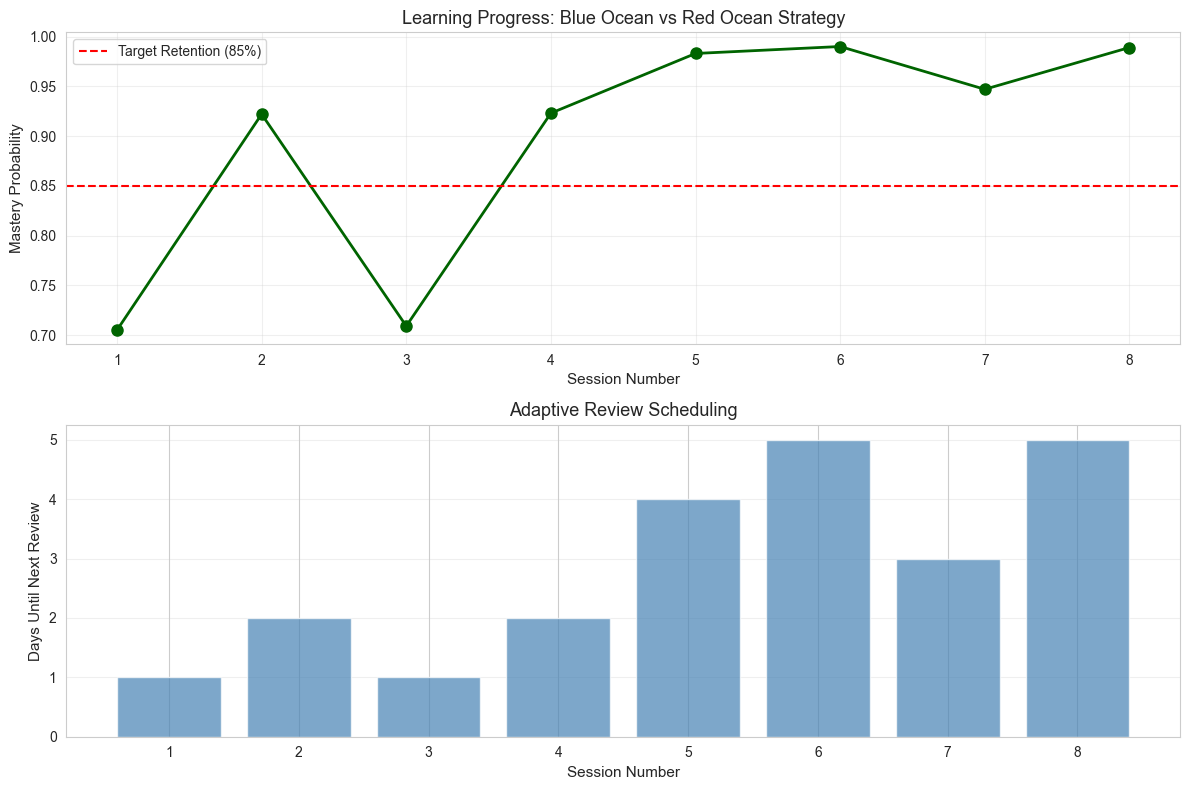


🎓 LEARNING OUTCOME SUMMARY

Starting Mastery:  30.0%
Final Mastery:     98.9%
Improvement:       +68.9 percentage points

Total Study Days:  23 days
Sessions Needed:   8 practice rounds

AI Efficiency:
  • Detected your mistake at Session 3 → shortened next review
  • Extended intervals as you showed consistent mastery
  • Final review scheduled 5 days out (you've got this!)

✅ CONCEPT MASTERED: Blue Ocean vs Red Ocean Strategy



In [11]:
print("="*80)
print("🎮 INTERACTIVE DEMONSTRATION")
print("="*80)

print("""
Let's simulate YOU learning a Business Strategy concept:
"Blue Ocean Strategy vs. Red Ocean Strategy"

You'll answer 8 practice questions over time, and the AI will adapt.
""")

# Initialize system for this demo
my_learning = PredictiveLearningSystem(
    student_speed=1.0,  # Average learner
    concept_name="Blue Ocean vs Red Ocean Strategy"
)

# Simulated learning journey with explanations
practice_sessions = [
    {
        'question': "Q1: Which strategy focuses on creating uncontested market space?",
        'your_answer': "Blue Ocean",
        'correct': True,
        'explanation': "First attempt - You got it right!"
    },
    {
        'question': "Q2: Red Ocean Strategy emphasizes...",
        'your_answer': "Competing in existing markets",
        'correct': True,
        'explanation': "Good! You understand the basic distinction."
    },
    {
        'question': "Q3: Which strategy makes competition irrelevant?",
        'your_answer': "Red Ocean",
        'correct': False,
        'explanation': "Oops! You confused them. Blue Ocean makes competition irrelevant."
    },
    {
        'question': "Q4: Value innovation is central to which strategy?",
        'your_answer': "Blue Ocean",
        'correct': True,
        'explanation': "Correct! You're recovering from the mistake."
    },
    {
        'question': "Q5: Which strategy focuses on beating the competition?",
        'your_answer': "Red Ocean",
        'correct': True,
        'explanation': "Perfect! Mastery is building."
    },
    {
        'question': "Q6: Example: Cirque du Soleil used which strategy?",
        'your_answer': "Blue Ocean",
        'correct': True,
        'explanation': "Exactly! They created a new market space."
    },
    {
        'question': "Q7: In Red Ocean, demand is...",
        'your_answer': "Created",
        'correct': False,
        'explanation': "Mistake! In Red Ocean, demand is FOUGHT OVER (not created)."
    },
    {
        'question': "Q8: Blue Ocean Strategy requires...",
        'your_answer': "Value innovation",
        'correct': True,
        'explanation': "Excellent! You've mastered the concept."
    }
]

print("\n📝 YOUR LEARNING SESSION:\n")

for i, session in enumerate(practice_sessions, 1):
    result = my_learning.process_answer(session['correct'])

    print(f"{'─'*70}")
    print(f"SESSION {i}")
    print(f"{'─'*70}")
    print(f"❓ {session['question']}")
    print(f"💭 Your Answer: {session['your_answer']}")
    print(f"{'✅' if session['correct'] else '❌'} {session['explanation']}")
    print()
    print(f"📊 AI Analysis:")
    print(f"   • Current Mastery: {result['mastery']:.1%}")
    print(f"   • Predicted Decay Rate: {result['decay']:.4f}")
    print(f"   • Next Review Scheduled: {result['days']} days from now")
    print(f"   • Priority: {result['urgency']}")
    print()

print("\n" + "="*80)
print("📈 YOUR COMPLETE LEARNING JOURNEY")
print("="*80)

final_history = my_learning.get_history()
print(final_history.to_string(index=False))

# Visualize your progress
my_learning.plot_progress()

# Final summary
final_mastery = result['mastery']
total_days = final_history['Days_to_Review'].sum()

print("\n" + "="*80)
print("🎓 LEARNING OUTCOME SUMMARY")
print("="*80)
print(f"""
Starting Mastery:  30.0%
Final Mastery:     {final_mastery:.1%}
Improvement:       +{(final_mastery - 0.30)*100:.1f} percentage points

Total Study Days:  {total_days} days
Sessions Needed:   8 practice rounds

AI Efficiency:
  • Detected your mistake at Session 3 → shortened next review
  • Extended intervals as you showed consistent mastery
  • Final review scheduled {result['days']} days out (you've got this!)

✅ CONCEPT MASTERED: Blue Ocean vs Red Ocean Strategy
""")

PROJECT COMPLETION CHECKLIST
